In [0]:

# Run this if in COLAB
!pip install --upgrade https://github.com/Theano/Theano/archive/master.zip
!pip install --upgrade https://github.com/Lasagne/Lasagne/archive/master.zip
    
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/bayes.py
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/action_rewards.npy
!wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week5_explore/all_states.npy

In [0]:
from abc import ABCMeta, abstractmethod, abstractproperty
import enum

import numpy as np
np.set_printoptions(precision=3)
np.set_printoptions(suppress=True)

import pandas

from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['axes.grid'] = False

## Contents
* [1. Bernoulli Bandit](#Part-1.-Bernoulli-Bandit)
    * [Bonus 1.1. Gittins index (5 points)](#Bonus-1.1.-Gittins-index-%285-points%29.)
    * [HW 1.1. Nonstationary Bernoulli bandit](#HW-1.1.-Nonstationary-Bernoulli-bandit)
* [2. Contextual bandit](#Part-2.-Contextual-bandit)
    * [2.1 Bulding a BNN agent](#2.1-Bulding-a-BNN-agent)
    * [2.2 Training the agent](#2.2-Training-the-agent)
    * [HW 2.1 Better exploration](#HW-2.1-Better-exploration)
* [3. Exploration in MDP](#Part-3.-Exploration-in-MDP)
    * [Bonus 3.1 Posterior sampling RL (3 points)](#Bonus-3.1-Posterior-sampling-RL-%283-points%29)
    * [Bonus 3.2 Bootstrapped DQN (10 points)](#Bonus-3.2-Bootstrapped-DQN-%2810-points%29)
    * [Bonus 3.3 Solve "Montezuma Revenge" with RL (100 points)](#Bonus-3.3-Solve-"Montezuma-Revenge"-with-RL-%28100-points%29)


## Part 1. Bernoulli Bandit

We are going to implement several exploration strategies for simplest problem - bernoulli bandit.

The bandit has $K$ actions. Action produce 1.0 reward $r$ with probability $0 \le \theta_k \le 1$ which is unknown to agent, but fixed over time. Agent's objective is to minimize regret over fixed number $T$ of action selections:

$$\rho = T\theta^* - \sum_{t=1}^T r_t$$

Where $\theta^* = \max_k\{\theta_k\}$

**Real-world analogy:**

Clinical trials - we have $K$ pills and $T$ ill patient. After taking pill, patient is cured with probability $\theta_k$. Task is to find most efficient pill.

A research on clinical trials - https://arxiv.org/pdf/1507.08025.pdf

In [0]:
class BernoulliBandit:
    def __init__(self, n_actions=5):
        self._probs = np.random.random(n_actions)

    @property
    def action_count(self):
        return len(self._probs)

    def pull(self, action):
        if np.random.random() > self._probs[action]:
            return 0.0
        return 1.0

    def optimal_reward(self):
        """ Used for regret calculation
        """
        return np.max(self._probs)

    def step(self):
        """ Used in nonstationary version
        """
        pass

    def reset(self):
        """ Used in nonstationary version
        """

In [0]:
class AbstractAgent(metaclass=ABCMeta):
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0

    @abstractmethod
    def get_action(self):
        """
        Get current best action
        :rtype: int
        """
        pass

    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1

    @property
    def name(self):
        return self.__class__.__name__


class RandomAgent(AbstractAgent):
    def get_action(self):
        return np.random.randint(0, len(self._successes))

### Epsilon-greedy agent

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $\hat\theta_k \leftarrow \alpha_k / (\alpha_k + \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$ with probability $1 - \epsilon$ or random action with probability $\epsilon$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

Implement the algorithm above in the cell below:

In [0]:
class EpsilonGreedyAgent(AbstractAgent):
    def __init__(self, epsilon=0.01):
        self._epsilon = epsilon

    def get_action(self):
        if np.random.uniform() < self._epsilon:
            action = np.random.randint(0, len(self._successes))
        else:
            n_a = self._successes+self._failures
            teta = np.divide(self._successes, n_a, out=0.5*np.ones_like(n_a), where=(n_a!=0))
            action = np.argmax(teta)
        return action

    @property
    def name(self):
        return self.__class__.__name__ + "(epsilon={})".format(self._epsilon)

### UCB Agent
Epsilon-greedy strategy heve no preference for actions. It would be better to select among actions that are uncertain or have potential to be optimal. One can come up with idea of index for each action that represents otimality and uncertainty at the same time. One efficient way to do it is to use UCB1 algorithm:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> $w_k \leftarrow \alpha_k / (\alpha_k + \beta_k) + \sqrt{2log\ t \ / \ (\alpha_k + \beta_k)}$

>> **end for** 

>> $x_t \leftarrow argmax_{k}w$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**

More versions and optimality analysis - https://homes.di.unimi.it/~cesabian/Pubblicazioni/ml-02.pdf

In [0]:
class UCBAgent(AbstractAgent):
    def get_action(self):
        n_a = self._successes+self._failures
        teta = np.divide(self._successes, n_a, out=0.5*np.ones_like(n_a), where=(n_a!=0))
        t = max(self._total_pulls,1)
        u_b = np.sqrt(np.divide(2*np.log(t),n_a,out=np.ones_like(n_a),where=(n_a!=0)))
        return np.argmax( teta + u_b )

### Thompson sampling

UCB1 algorithm does not take into account actual distribution of rewards. If we know the distribution - we can do much better by using Thompson sampling:

> **for** $t = 1,2,...$ **do**
>> **for** $k = 1,...,K$ **do**
>>> Sample $\hat\theta_k \sim beta(\alpha_k, \beta_k)$

>> **end for** 

>> $x_t \leftarrow argmax_{k}\hat\theta$

>> Apply $x_t$ and observe $r_t$

>> $(\alpha_{x_t}, \beta_{x_t}) \leftarrow (\alpha_{x_t}, \beta_{x_t}) + (r_t, 1-r_t)$

> **end for**
 

More on Tompson Sampling:
https://web.stanford.edu/~bvr/pubs/TS_Tutorial.pdf

In [0]:
class ThompsonSamplingAgent(AbstractAgent):
    def get_action(self):
        samples = np.random.beta(np.maximum(self._successes,0.5),np.maximum(self._failures,0.5))
        return np.argmax(samples)

In [0]:
def plot_regret(env, agents, n_steps=5000, n_trials=50):
    scores = {
        agent.name: [0.0 for step in range(n_steps)] for agent in agents
    }

    for trial in range(n_trials):
        env.reset()

        for a in agents:
            a.init_actions(env.action_count)

        for i in range(n_steps):
            optimal_reward = env.optimal_reward()

            for agent in agents:
                action = agent.get_action()
                reward = env.pull(action)
                agent.update(action, reward)
                scores[agent.name][i] += optimal_reward - reward

            env.step()  # change bandit's state if it is unstationary

    plt.figure(figsize=(17, 8))
    for agent in agents:
        plt.plot(np.cumsum(scores[agent.name]) / n_trials)

    plt.legend([agent.name for agent in agents])

    plt.ylabel("regret")
    plt.xlabel("steps")

    plt.show()

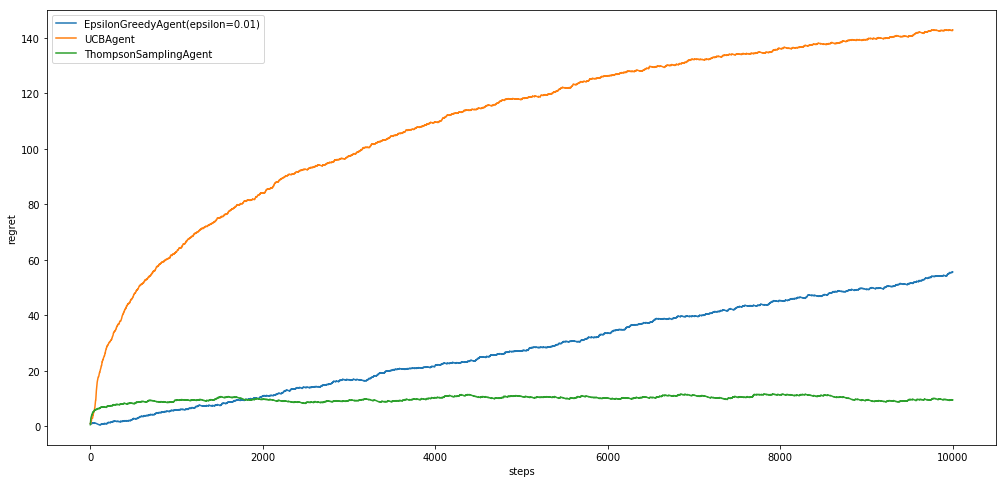

In [0]:
agents = [
        EpsilonGreedyAgent(),
        UCBAgent(),
        ThompsonSamplingAgent()
]

plot_regret(BernoulliBandit(), agents, n_steps=10000, n_trials=10)

**As we see the most successful agent is the Thompson sampling agent. UCB agent has considerably larger regret than the EpsilonGreedy one at step 4000, but the first agent's regret is sublinear function while the second's is linear. So EpsilonGreedy is the worst in the long term.**

# Bonus 1.1. Gittins index (5 points).

Bernoulli bandit problem has an optimal solution - Gittins index algorithm. Implement finite horizon version of the algorithm and demonstrate it's performance with experiments. some articles:
- Wikipedia article - https://en.wikipedia.org/wiki/Gittins_index
- Different algorithms for index computation - http://www.ece.mcgill.ca/~amahaj1/projects/bandits/book/2013-bandit-computations.pdf (see "Bernoulli" section)
    

# HW 1.1. Nonstationary Bernoulli bandit

What if success probabilities change over time? Here is an example of such bandit:

In [0]:
class DriftingBandit(BernoulliBandit):
    def __init__(self, n_actions=5, gamma=0.01):
        """
        Idea from https://github.com/iosband/ts_tutorial
        """
        super().__init__(n_actions)

        self._gamma = gamma

        self._successes = None
        self._failures = None
        self._steps = 0

        self.reset()

    def reset(self):
        self._successes = np.zeros(self.action_count) + 1.0
        self._failures = np.zeros(self.action_count) + 1.0
        self._steps = 0

    def step(self):
        action = np.random.randint(self.action_count)
        reward = self.pull(action)
        self._step(action, reward)

    def _step(self, action, reward):
        self._successes = self._successes * (1 - self._gamma) + self._gamma
        self._failures = self._failures * (1 - self._gamma) + self._gamma
        self._steps += 1

        self._successes[action] += reward
        self._failures[action] += 1.0 - reward

        self._probs = np.random.beta(self._successes, self._failures)

And a picture how it's reward probabilities change over time

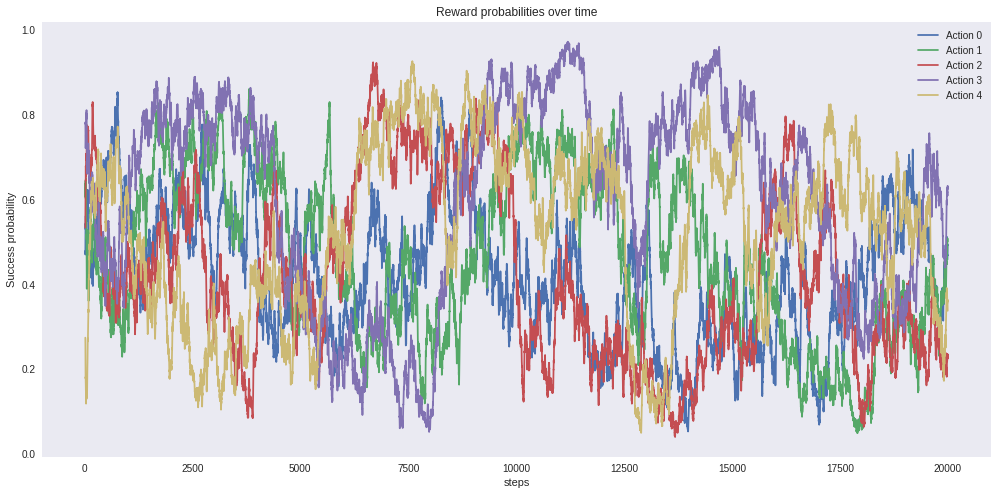

In [0]:
drifting_env = DriftingBandit(n_actions=5)

drifting_probs = []
for i in range(20000):
    drifting_env.step()
    drifting_probs.append(drifting_env._probs)

plt.figure(figsize=(17, 8))
plt.plot(pandas.DataFrame(drifting_probs).rolling(window=20).mean())

plt.xlabel("steps")
plt.ylabel("Success probability")
plt.title("Reward probabilities over time")
plt.legend(["Action {}".format(i) for i in range(drifting_env.action_count)])
plt.show()

Your task is to invent an agent that will have better regret than stationary agents from above.

**Because properties of bandit change over time we need to freely update parameters and constantly explore. We can achieve this by forcing the agent remember only last $n$ steps. Optimal $n$ depends on nature of non-stationarity and also bandit properties shouldn't significantly change over time periods that are sufficient to identify effective action, but anyway.**

**Thompson Sampling performs well when there is prior knowledge for reward distribution but in this case distribution varies over time. So we will use UCB**

In [0]:
from collections import deque

class ForgettingAgent(UCBAgent):
    def __init__(self, memory_size):
        self.history = deque(maxlen=memory_size)
        self.memory_size = memory_size
        
    def init_actions(self, n_actions):
        self._successes = np.zeros(n_actions)
        self._failures = np.zeros(n_actions)
        self._total_pulls = 0
        self.history.clear()
        
    def update(self, action, reward):
        """
        Observe reward from action and update agent's internal parameters
        :type action: int
        :type reward: int
        """
        self._total_pulls += 1

        
        if len(self.history) == self.memory_size:
            self._total_pulls -= 1
            a, r = self.history[0]
            if r == 1:
                self._successes[a] -= 1
            else:
                self._failures[a] -= 1
                
        if reward == 1:
            self._successes[action] += 1
        else:
            self._failures[action] += 1
        
        self.history.append((action,reward))    

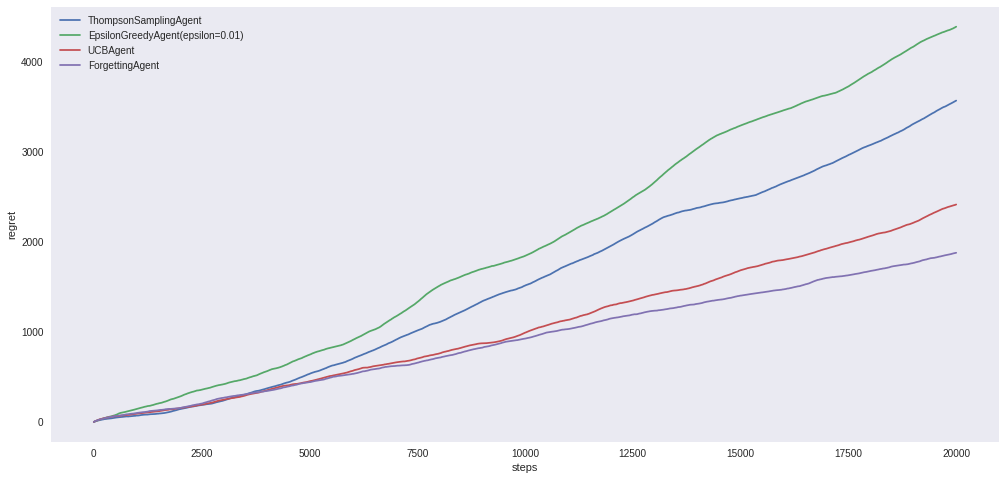

In [0]:
drifting_agents = [
    ThompsonSamplingAgent(),
    EpsilonGreedyAgent(),
    UCBAgent(),
    ForgettingAgent(3000)
]

plot_regret(DriftingBandit(), drifting_agents, n_steps=20000, n_trials=10)

**As we see our agent outperformed other agents.**

**It seems that regrets grow linearly. In general case, when properties of bandit change unpredictably,  we can't do  any better.**

## Part 2. Contextual bandit

Now we will solve much more complex problem - reward will depend on bandit's state.

**Real-word analogy:**

> Contextual advertising. We have a lot of banners and a lot of different users. Users can have different features: age, gender, search requests. We want to show banner with highest click probability.

If we want use strategies from above, we need some how store reward distributions conditioned both on actions and bandit's state. 
One way to do this - use bayesian neural networks. Instead of giving pointwise estimates of target, they maintain probability distributions

![img](https://github.com/simplerick/Practical_RL/raw/spring19/yet_another_week/_resource/bnn.png) 

Picture from https://arxiv.org/pdf/1505.05424.pdf


More material:
  * A post on the matter - [url](http://twiecki.github.io/blog/2016/07/05/bayesian-deep-learning/)
  * Theano+PyMC3 for more serious stuff - [url](http://pymc-devs.github.io/pymc3/notebooks/bayesian_neural_network_advi.html)
  * Same stuff in tensorflow - [url](http://edwardlib.org/tutorials/bayesian-neural-network)
  
Let's load our dataset:

In [0]:
all_states = np.load("all_states.npy")
action_rewards = np.load("action_rewards.npy")

state_size = all_states.shape[1]
n_actions = action_rewards.shape[1]

print("State size: %i, actions: %i" % (state_size, n_actions))

State size: 60, actions: 10


In [0]:
import theano
import theano.tensor as T
import lasagne
from lasagne import init
from lasagne.layers import *
import bayes

as_bayesian = bayes.bbpwrap(bayes.NormalApproximation(std=0.1))
BayesDenseLayer = as_bayesian(DenseLayer)

## 2.1 Bulding a BNN agent

Let's implement epsilon-greedy BNN agent

In [0]:
class BNNAgent:
    """a bandit with bayesian neural net"""

    def __init__(self, state_size, n_actions):
        input_states = T.matrix("states")
        target_actions = T.ivector("actions taken")
        target_rewards = T.vector("rewards")
        self.n_actions = n_actions

        self.total_samples_seen = theano.shared(
            np.int32(0), "number of training samples seen so far")
        batch_size = target_actions.shape[0]  # por que?

        # Network
        inp = InputLayer((None, state_size), name='input')
        # YOUR NETWORK HERE
        hid = BayesDenseLayer(inp, num_units=100)
        out = BayesDenseLayer(hid,num_units=n_actions)

        # Prediction
        prediction_all_actions = get_output(out, inputs=input_states)
        self.predict_sample_rewards = theano.function(
            [input_states], prediction_all_actions)

        # Training

        # select prediction for target action
        prediction_target_actions = prediction_all_actions[T.arange(
            batch_size), target_actions]

        # loss = negative log-likelihood (mse) + KL
        negative_llh = T.sum((prediction_target_actions - target_rewards)**2)

        kl = bayes.get_var_cost(out) / (self.total_samples_seen+batch_size)

        loss = (negative_llh + kl)/batch_size

        self.weights = get_all_params(out, trainable=True)
        self.out = out

        # gradient descent
        updates = lasagne.updates.adam(loss, self.weights)
        # update counts
        updates[self.total_samples_seen] = self.total_samples_seen + \
            batch_size.astype('int32')

        self.train_step = theano.function([input_states, target_actions, target_rewards],
                                          [negative_llh, kl],
                                          updates=updates,
                                          allow_input_downcast=True)

    def sample_prediction(self, states, n_samples=1):
        """Samples n_samples predictions for rewards,

        :returns: tensor [n_samples, state_i, action_i]
        """
        assert states.ndim == 2, "states must be 2-dimensional"

        return np.stack([self.predict_sample_rewards(states) for _ in range(n_samples)])

    epsilon = 0.25

    def get_action(self, states):
        """
        Picks action by 
        - with p=1-epsilon, taking argmax of average rewards
        - with p=epsilon, taking random action
        This is exactly e-greedy policy.
        """

        reward_samples = self.sample_prediction(states, n_samples=100)
        # ^-- samples for rewards, shape = [n_samples,n_states,n_actions]

        best_actions = reward_samples.mean(axis=0).argmax(axis=-1)
        # ^-- we take mean over samples to compute expectation, then pick best action with argmax

        # YOUR CODE HERE
        random_actions = np.random.randint(0,self.n_actions, size=best_actions.shape[0])
        mask = (np.random.random_sample(random_actions.shape) < self.epsilon)
        chosen_actions = random_actions*mask + best_actions*(1-mask)

        return chosen_actions

    def train(self, states, actions, rewards, n_iters=10):
        """
        trains to predict rewards for chosen actions in given states
        """
        loss_sum = kl_sum = 0
        for _ in range(n_iters):
            loss, kl = self.train_step(states, actions, rewards)
            loss_sum += loss
            kl_sum += kl

        return loss_sum / n_iters, kl_sum / n_iters

    @property
    def name(self):
        return self.__class__.__name__

## 2.2 Training the agent

In [0]:
N_ITERS = 300

In [0]:
def get_new_samples(states, action_rewards, batch_size=10):
    """samples random minibatch, emulating new users"""
    batch_ix = np.random.randint(0, len(states), batch_size)
    return states[batch_ix], action_rewards[batch_ix]

In [0]:
from IPython.display import clear_output
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values


def train_contextual_agent(agent, batch_size=10, n_iters=100):
    rewards_history = []

    for i in range(n_iters):
        b_states, b_action_rewards = get_new_samples(
            all_states, action_rewards, batch_size)
        b_actions = agent.get_action(b_states)
        b_rewards = b_action_rewards[
            np.arange(batch_size), b_actions
        ]

        mse, kl = agent.train(b_states, b_actions, b_rewards, n_iters=100)

        rewards_history.append(b_rewards.mean())

        if i % 10 == 0:
            clear_output(True)
            print("iteration #%i\tmean reward=%.3f\tmse=%.3f\tkl=%.3f" %
                  (i, np.mean(rewards_history[-10:]), mse, kl))
            plt.plot(rewards_history)
            plt.plot(moving_average(np.array(rewards_history), alpha=0.1))
            plt.title("Reward per epesode")
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.show()

            samples = agent.sample_prediction(
                b_states[:1], n_samples=100).T[:, 0, :]
            for i in range(len(samples)):
                plt.hist(samples[i], alpha=0.25, label=str(i))
                plt.legend(loc='best')
            print('Q(s,a) std:', ';'.join(
                list(map('{:.3f}'.format, np.std(samples, axis=1)))))
            print('correct', b_action_rewards[0].argmax())
            plt.title("p(Q(s, a))")
            plt.show()

    return moving_average(np.array(rewards_history), alpha=0.1)

iteration #290	mean reward=0.670	mse=0.197	kl=0.020


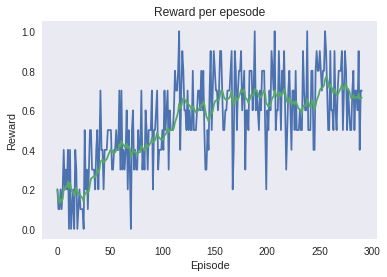

Q(s,a) std: 0.063;0.024;0.071;0.045;0.005;0.000;0.079;0.052;0.093;0.013
correct 8


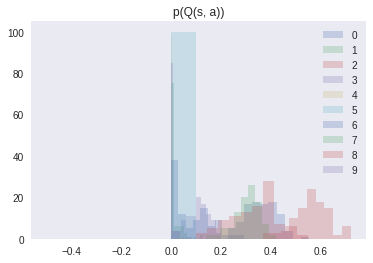

In [0]:
bnn_agent = BNNAgent(state_size=state_size, n_actions=n_actions)
greedy_agent_rewards = train_contextual_agent(
    bnn_agent, batch_size=10, n_iters=N_ITERS)

## HW 2.1 Better exploration

Use strategies from first part to gain more reward in contextual setting

In [0]:
class ThompsonBNNAgent(BNNAgent):
    def get_action(self, states):
        """
        picks action based by taking _one_ sample from BNN and taking action with highest sampled reward (yes, that simple)
        This is exactly thompson sampling.
        """

        reward_samples = self.sample_prediction(states, n_samples=1).squeeze()
        chosen_actions = reward_samples.argmax(axis=-1)
        return chosen_actions

iteration #290	mean reward=0.850	mse=0.060	kl=0.019


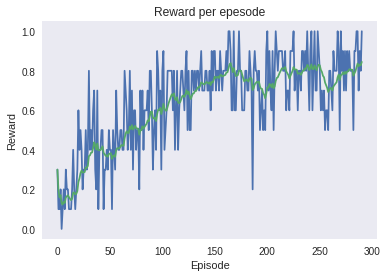

Q(s,a) std: 0.047;0.000;0.038;0.099;0.055;0.000;0.116;0.166;0.037;0.052
correct 0


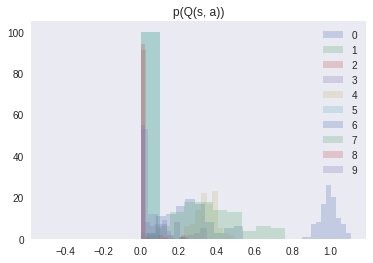

In [0]:
tompson_agent_rewards = train_contextual_agent(ThompsonBNNAgent(state_size=state_size, n_actions=n_actions),
                                               batch_size=10, n_iters=N_ITERS)

In [0]:
class BayesUCBBNNAgent(BNNAgent):
    q = 90

    def get_action(self, states):
        """
        Compute q-th percentile of rewards P(r|s,a) for all actions
        Take actions that have highest percentiles.

        This implements bayesian UCB strategy
        """
        reward_samples = self.sample_prediction(states, n_samples=100)
        percentiles = np.percentile(reward_samples, self.q, axis=0)
        chosen_actions = percentiles.argmax(axis=-1)
        return chosen_actions
        

iteration #290	mean reward=0.910	mse=0.150	kl=0.018


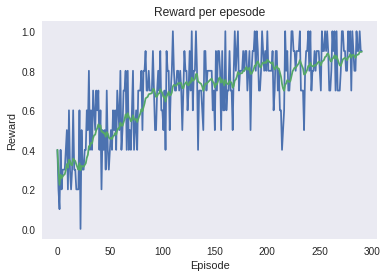

Q(s,a) std: 0.064;0.001;0.049;0.070;0.032;0.048;0.035;0.003;0.097;0.106
correct 8


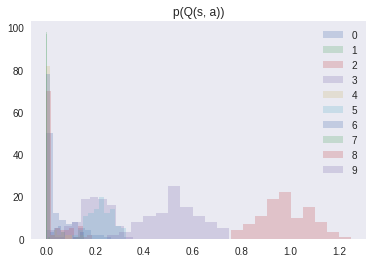

In [0]:
ucb_agent_rewards = train_contextual_agent(BayesUCBBNNAgent(state_size=state_size, n_actions=n_actions),
                                           batch_size=10, n_iters=N_ITERS)

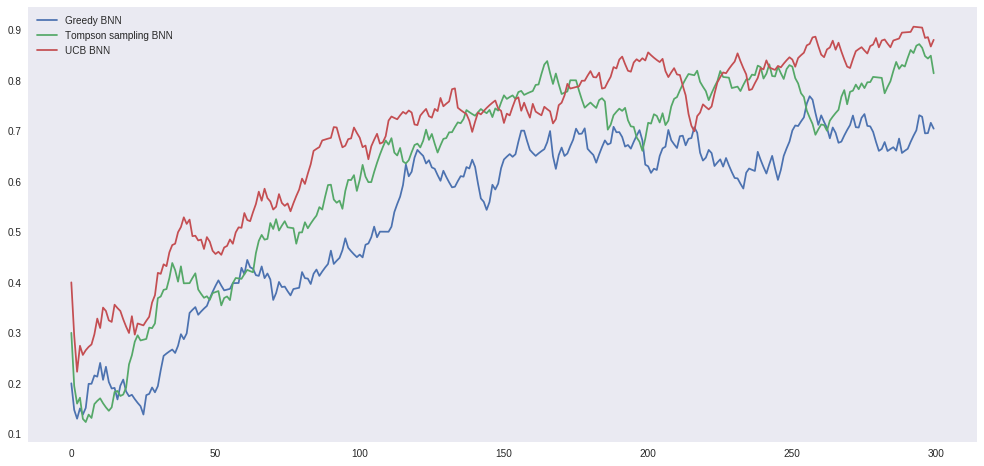

In [0]:
plt.figure(figsize=(17, 8))

plt.plot(greedy_agent_rewards)
plt.plot(tompson_agent_rewards)
plt.plot(ucb_agent_rewards)

plt.legend([
    "Greedy BNN",
    "Tompson sampling BNN",
    "UCB BNN"
])

plt.show()

**As expected, ThompsonSampling and UCB performed better than Epsilon Greedy. Probably UCB has some advantage over Thompson in that it uses more samples when selecting actions and therefore can converge faster.**

## Part 3. Exploration in MDP

The following problem, called "river swim", illustrates importance of exploration in context of mdp's.

![img](https://github.com/simplerick/Practical_RL/raw/spring19/yet_another_week/_resource/river_swim.png)

Picture from https://arxiv.org/abs/1306.0940

Rewards and transition probabilities are unknown to an agent. Optimal policy is to swim against current, while easiest way to gain reward is to go left.

In [0]:
class RiverSwimEnv:
    LEFT_REWARD = 5.0 / 1000
    RIGHT_REWARD = 1.0

    def __init__(self, intermediate_states_count=4, max_steps=16):
        self._max_steps = max_steps
        self._current_state = None
        self._steps = None
        self._interm_states = intermediate_states_count
        self.reset()

    def reset(self):
        self._steps = 0
        self._current_state = 1
        return self._current_state, 0.0, False

    @property
    def n_actions(self):
        return 2

    @property
    def n_states(self):
        return 2 + self._interm_states

    def _get_transition_probs(self, action):
        if action == 0:
            if self._current_state == 0:
                return [0, 1.0, 0]
            else:
                return [1.0, 0, 0]

        elif action == 1:
            if self._current_state == 0:
                return [0, .4, .6]
            if self._current_state == self.n_states - 1:
                return [.4, .6, 0]
            else:
                return [.05, .6, .35]
        else:
            raise RuntumeError(
                "Unknown action {}. Max action is {}".format(action, self.n_actions))

    def step(self, action):
        """
        :param action:
        :type action: int
        :return: observation, reward, is_done
        :rtype: (int, float, bool)
        """
        reward = 0.0

        if self._steps >= self._max_steps:
            return self._current_state, reward, True

        transition = np.random.choice(
            range(3), p=self._get_transition_probs(action))
        if transition == 0:
            self._current_state -= 1
        elif transition == 1:
            pass
        else:
            self._current_state += 1

        if self._current_state == 0:
            reward = self.LEFT_REWARD
        elif self._current_state == self.n_states - 1:
            reward = self.RIGHT_REWARD

        self._steps += 1
        return self._current_state, reward, False

Let's implement q-learning agent with epsilon-greedy exploration strategy and see how it performs.

In [0]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, lr=0.2, gamma=0.95, epsilon=0.1):
        self._gamma = gamma
        self._epsilon = epsilon
        self._q_matrix = np.zeros((n_states, n_actions))
        self._lr = lr

    def get_action(self, state):
        if np.random.random() < self._epsilon:
            return np.random.randint(0, self._q_matrix.shape[1])
        else:
            return np.argmax(self._q_matrix[state])

    def get_q_matrix(self):
        """ Used for policy visualization
        """

        return self._q_matrix

    def start_episode(self):
        """ Used in PSRL agent
        """
        pass

    def update(self, state, action, reward, next_state):
        # YOUR CODE HERE
        # Finish implementation of q-learnig agent

In [0]:
def train_mdp_agent(agent, env, n_episodes):
    episode_rewards = []

    for ep in range(n_episodes):
        state, ep_reward, is_done = env.reset()
        agent.start_episode()
        while not is_done:
            action = agent.get_action(state)

            next_state, reward, is_done = env.step(action)
            agent.update(state, action, reward, next_state)

            state = next_state
            ep_reward += reward

        episode_rewards.append(ep_reward)
    return episode_rewards

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:6: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  


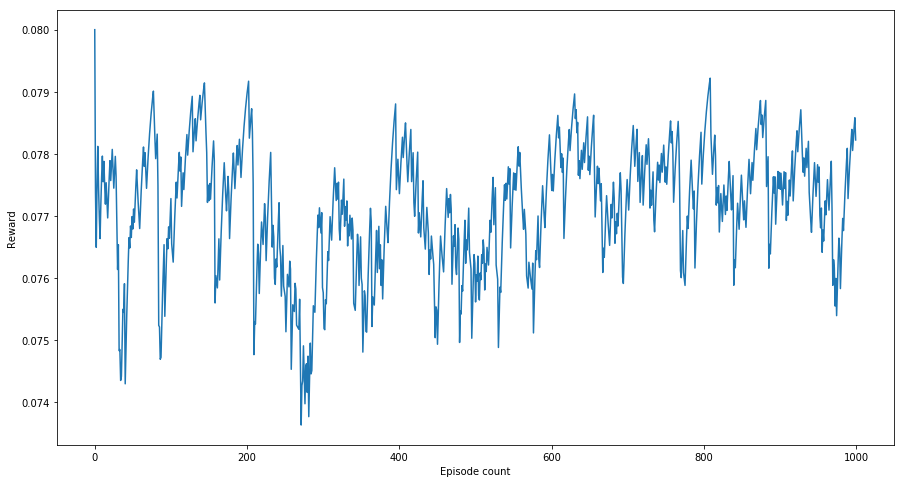

In [0]:
env = RiverSwimEnv()
agent = QLearningAgent(env.n_states, env.n_actions)
rews = train_mdp_agent(agent, env, 1000)
plt.figure(figsize=(15, 8))

plt.plot(moving_average(np.array(rews), alpha=.1))
plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

Let's visualize our policy:

In [0]:
def plot_policy(agent):
    fig = plt.figure(figsize=(15, 8))
    ax = fig.add_subplot(111)
    ax.matshow(agent.get_q_matrix().T)
    ax.set_yticklabels(['', 'left', 'right'])
    plt.xlabel("State")
    plt.ylabel("Action")
    plt.title("Values of state-action pairs")
    plt.show()

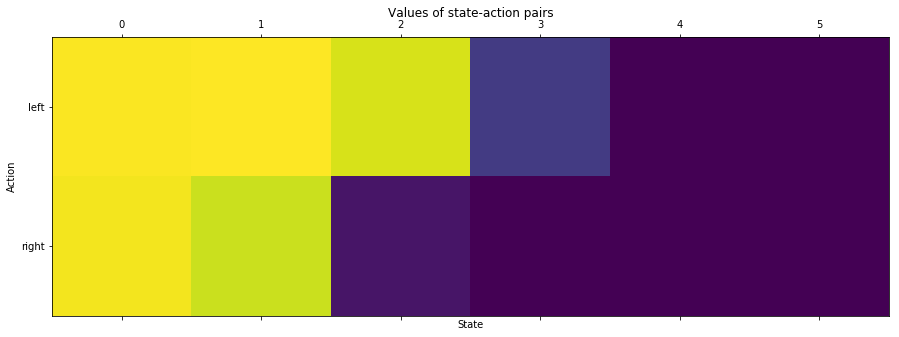

In [0]:
plot_policy(agent)

As your see, agent uses suboptimal policy of going left and does not explore the right state.

## Bonus 3.1 Posterior sampling RL (3 points)

Now we will implement Tompson Sampling for MDP!

General algorithm:

>**for** episode $k = 1,2,...$ **do**
>> sample $M_k \sim f(\bullet\ |\ H_k)$

>> compute policy $\mu_k$ for $M_k$

>> **for** time $t = 1, 2,...$ **do**

>>> take action  $a_t$ from $\mu_k$ 

>>> observe $r_t$ and $s_{t+1}$
>>> update $H_k$

>> **end for**

>**end for**

In our case we will model $M_k$ with two matricies: transition and reward. Transition matrix is sampled from dirichlet distribution. Reward matrix is sampled from normal-gamma distribution.

Distributions are updated with bayes rule - see continious distribution section at https://en.wikipedia.org/wiki/Conjugate_prior

Article on PSRL - https://arxiv.org/abs/1306.0940

In [0]:
def sample_normal_gamma(mu, lmbd, alpha, beta):
    """ https://en.wikipedia.org/wiki/Normal-gamma_distribution
    """
    tau = np.random.gamma(alpha, beta)
    mu = np.random.normal(mu, 1.0 / np.sqrt(lmbd * tau))
    return mu, tau


class PsrlAgent:
    def __init__(self, n_states, n_actions, horizon=10):
        self._n_states = n_states
        self._n_actions = n_actions
        self._horizon = horizon

        # params for transition sampling - Dirichlet distribution
        self._transition_counts = np.zeros(
            (n_states, n_states, n_actions)) + 1.0

        # params for reward sampling - Normal-gamma distribution
        self._mu_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._state_action_counts = np.zeros(
            (n_states, n_actions)) + 1.0  # lambda

        self._alpha_matrix = np.zeros((n_states, n_actions)) + 1.0
        self._beta_matrix = np.zeros((n_states, n_actions)) + 1.0

    def _value_iteration(self, transitions, rewards):
        # YOU CODE HERE
        state_values = < Find action values with value iteration >
        return state_values

    def start_episode(self):
        # sample new  mdp
        self._sampled_transitions = np.apply_along_axis(
            np.random.dirichlet, 1, self._transition_counts)

        sampled_reward_mus, sampled_reward_stds = sample_normal_gamma(
            self._mu_matrix,
            self._state_action_counts,
            self._alpha_matrix,
            self._beta_matrix
        )

        self._sampled_rewards = sampled_reward_mus
        self._current_value_function = self._value_iteration(
            self._sampled_transitions, self._sampled_rewards)

    def get_action(self, state):
        return np.argmax(self._sampled_rewards[state] +
                         self._current_value_function.dot(self._sampled_transitions[state]))

    def update(self, state, action, reward, next_state):
        # YOUR CODE HERE
        # update rules - https://en.wikipedia.org/wiki/Conjugate_prior

    def get_q_matrix(self):
        return self._sampled_rewards + self._current_value_function.dot(self._sampled_transitions)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:7: FutureWarning: pd.ewm_mean is deprecated for ndarrays and will be removed in a future version
  import sys


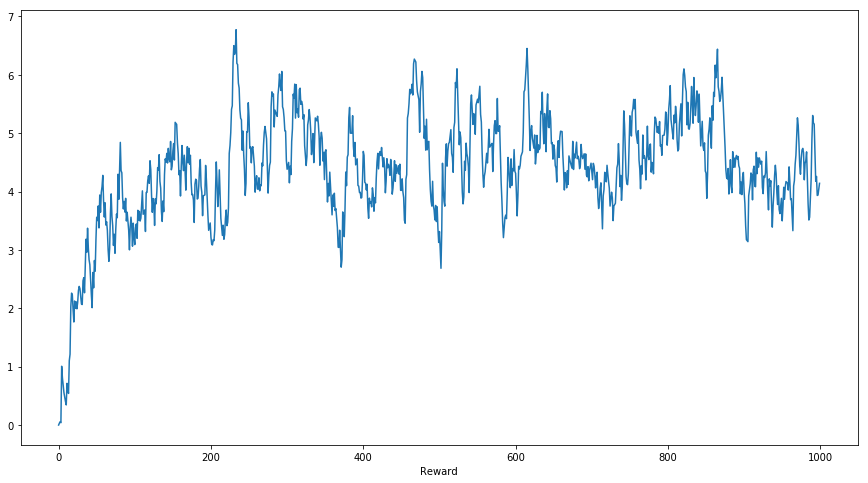

In [0]:
from pandas import DataFrame
moving_average = lambda x, **kw: DataFrame(
    {'x': np.asarray(x)}).x.ewm(**kw).mean().values

horizon = 20
env = RiverSwimEnv(max_steps=horizon)
agent = PsrlAgent(env.n_states, env.n_actions, horizon=horizon)
rews = train_mdp_agent(agent, env, 1000)

plt.figure(figsize=(15, 8))
plt.plot(moving_average(np.array(rews), alpha=0.1))

plt.xlabel("Episode count")
plt.ylabel("Reward")
plt.show()

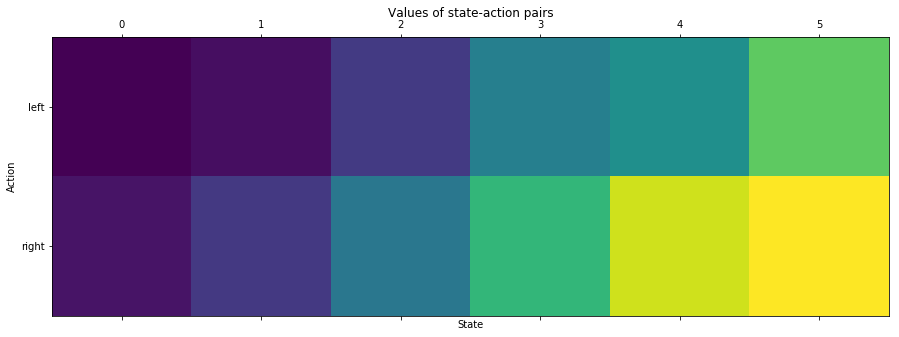

In [0]:
plot_policy(agent)

## Bonus 3.2 Bootstrapped DQN (10 points)

Implement Bootstrapped DQN algorithm and compare it's performance with ordinary DQN on BeamRider Atari game. Links:
- https://arxiv.org/abs/1602.04621